# Processing the results of the motif search

In [182]:
import nengo
import multiprocessing
import numpy as np
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from hashids import Hashids
import cpg_search
reload(cpg_search)
import cpg_search.run_motif_search
reload(cpg_search.run_motif_search)
import cpg_search.utils
reload(cpg_search.utils)
import cpg_search.plotting
reload(cpg_search.plotting)
from cpg_search.run_motif_search import *
from cpg_search.utils import *
from cpg_search.plotting import *
import os
import scipy
from tqdm import tqdm
import networkx as nx
import time
import itertools

## Function defs

In [209]:
def sin_fit(x, a, b,c,e):
    ret = a * np.sin(b * x + c) + e
    
    return ret

    
    
    

def process_fn(top, fn, tslc=slice(1000,None)):
    with open(os.path.join(datapath,fn), 'rb') as fp:
        ret = pickle.load(fp)
    
    fig, axs = plt.subplots(1,4,figsize=(12,4))
    ax = axs[0]
    ret['motor_values'] = np.array(ret['motor_values'])
    ax.scatter(ret['time'][tslc], ret['motor_values'][tslc,0], s=0.1, color='tab:blue', alpha=1)
    ax.scatter(ret['time'][tslc], ret['motor_values'][tslc,1], s=0.1, color='tab:orange')
    ax = axs[0]
    params = tuple(top.loc[fn,['a1','b1','c1','e1']])
    print('m1 params: %s' % str(params))
    cov = top.loc[fn, 'cov1']
    err = top.loc[fn,'err1']
    fit = top.loc[fn,'fit1'][0]
#     l1 = ax.plot(ret['time'][tslc],  fit, color='tab:blue', lw=2, alpha=0.2)[0]
    l1 = ax.plot(ret['time'][tslc], sin_fit(np.array(ret['time']).ravel(), *params)[tslc], color='tab:blue', lw=2, alpha=0.2)[0]
#     axs[1].scatter(ret['time'][tslc], (ret['motor_values'][tslc,0]  - params[-1])/params[0], s=0.1, color='tab:blue', alpha=1)

    params = tuple(top.loc[fn,['a2','b2','c2','e2']])
    print('m2 params: %s' % str(params))
    cov = top.loc[fn, 'cov2']
    err = top.loc[fn,'err2']
    fit = top.loc[fn,'fit2'][0]
    l2 = ax.plot(ret['time'][tslc], sin_fit(np.array(ret['time']).ravel(), *params)[tslc], color='tab:orange', lw=2, alpha=0.2)[0]
#     l2 = ax.plot(ret['time'][tslc],fit, color='tab:orange', lw=2, alpha=0.2)[0]
#     axs[1].scatter(ret['time'][tslc], (ret['motor_values'][tslc,1] - params[-1])/params[0], s=0.1, color='tab:orange')
#     ax.title.set_text("err : {}, params : {}".format(np.round(err,4),np.round(params,2)))
    plot_limit_cycle(ret, axs[1],tslc=slice(0,3000))
    ax.legend([l1,l2],['M1','M2'])
    ax.set_ylabel('Value')
    ax.set_xlabel('Time')
    ax = axs[1]
    
    axs[0].title.set_text('Data and fit')
#     axs[1].title.set_text('Rescaled data')
    axs[2].title.set_text('Structure')
    axs[3].title.set_text('Adjacency matrix')
                                                   
    
    fig.suptitle('Rank {} Fitness: {:.2f} Phase: {:.2f}'.format(top.index.get_loc(fn),top.loc[fn,'fitness'],top.loc[fn,'phase_diff']))
    adj = create_adj_matrix(*ret['_metadata'],modules=2)
    draw_graph(axs[2], adj,2)
    draw_adj(axs[3], adj)
    fig,axs = plt.subplots(2,1)
    
    axs[0].imshow(ret['spikes'][0].T, aspect='auto')
    axs[1].imshow(ret['spikes'][1].T, aspect='auto')

## Data load

In [185]:
raw_df = pd.read_pickle('sin_fit_results_df_s2_f_sc-1.pkl')
datapath = './data_s2_s0_f_sc-1'
raw_df['fitness'] = -np.inf
raw_df['phase_diff'] = -np.inf
gtslc = slice(3000,4000)

m1 params: (0.9204026490498721, 0.676968675622825, 5.6065817838797045, -0.5215970679517673)
m2 params: (10.038094338992032, 0.9580809657499757, 4.901011421983705, 3.3143339041368005)
(0, 0, 0.0)
(300, 300, 0.1)
(600, 600, 0.2)
(900, 900, 0.3)
(1200, 1200, 0.4)
(1500, 1500, 0.5)
(1800, 1800, 0.6)
(2100, 2100, 0.7)
(2400, 2400, 0.8)
(2700, 2700, 0.9)
(3000, 3000, 1.0)
(16, 2)


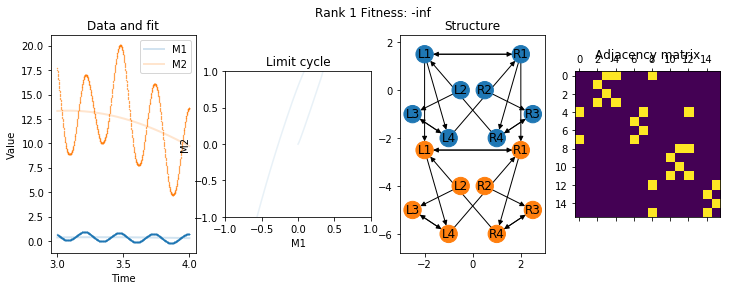

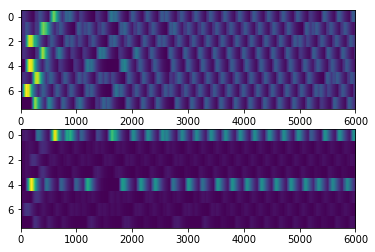

In [186]:
process_fn(raw_df,raw_df.index[1], tslc=gtslc)

## Apply filters

In [224]:
# Filter out small amplitude waves -- usually means that there was no output
df = raw_df.copy()
df['phase_diff'] = df.apply(get_phase_diff,axis=1)
df = df.query("abs(a1) >= 1e-2 & abs(a2) >= 1e-2")
# Filter out super low frequency waves -- usually bad fit
# df = df.query("b1 > 2 & b2 > 2")
# We want the phase difference to be significant
# df = df.query("abs(c1 - c2) > 1")
df = df.query("phase_diff > 0.3")
len(df)

751

## Evaluate fitness function on parameters and error

In [225]:
target_phase = np.pi/6
print('target_phase : {}'.format(target_phase))
def get_phase_diff(r):
    phase = (r.c1 - r.c2) % (np.pi/2)
    return phase
def get_phase_fitness(r):
    
    fitness = np.abs(r.phase_diff-target_phase)
    return fitness
def get_phase_err_fitness(r):
    phase_err = get_phase_fitness(r)
    err = r.err1 + r.err2
    a = 0.5
    b = 10
    fitness = a*err + b*phase_err
    return fitness

target_phase : 0.523598775598


In [226]:
# df['fitness'] = df.apply(lambda r: r.err, axis=1)
# df['fitness'] = df.apply(lambda r: r.a, axis=1)
# df['fitness'] = df['err']

# df['fitness'] = df.apply(get_phase_fitness , axis=1)
df['fitness'] = df.apply(get_phase_err_fitness , axis=1)

In [227]:
fit_sorted = df.sort_values(by='fitness')
top = fit_sorted.head(10)


## Top performers

m1 params: (0.46287097358141555, 24.008761855979934, -1.667987395447267, 0.002379039211843537)
m2 params: (0.46349394462102156, 23.992628514501423, -1.6403831367331065, 0.002939189842523285)
(0, 0, 0.0)
(300, 300, 0.1)
(600, 600, 0.2)
(900, 900, 0.3)
(1200, 1200, 0.4)
(1500, 1500, 0.5)
(1800, 1800, 0.6)
(2100, 2100, 0.7)
(2400, 2400, 0.8)
(2700, 2700, 0.9)
(3000, 3000, 1.0)
(16, 2)
m1 params: (0.46287097358141555, 24.008761855979934, -1.667987395447267, 0.002379039211843537)
m2 params: (0.46349394462102156, 23.992628514501423, -1.6403831367331065, 0.002939189842523285)
(0, 0, 0.0)
(300, 300, 0.1)
(600, 600, 0.2)
(900, 900, 0.3)
(1200, 1200, 0.4)
(1500, 1500, 0.5)
(1800, 1800, 0.6)
(2100, 2100, 0.7)
(2400, 2400, 0.8)
(2700, 2700, 0.9)
(3000, 3000, 1.0)
(16, 2)
m1 params: (0.46287097358141555, 24.008761855979934, -1.667987395447267, 0.002379039211843537)
m2 params: (0.46349394462102156, 23.992628514501423, -1.6403831367331065, 0.002939189842523285)
(0, 0, 0.0)
(300, 300, 0.1)
(600, 600, 

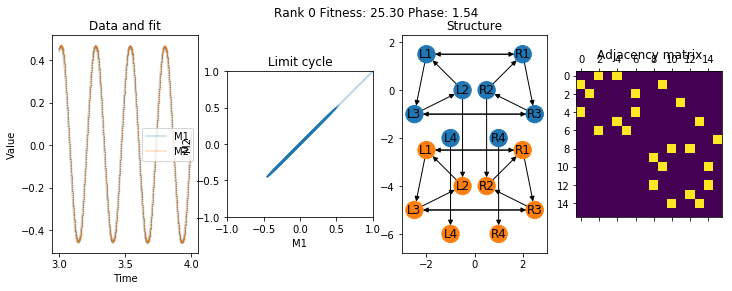

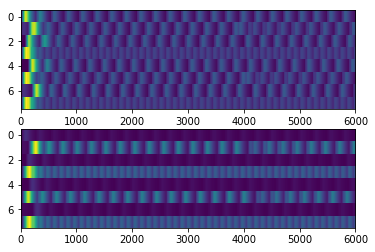

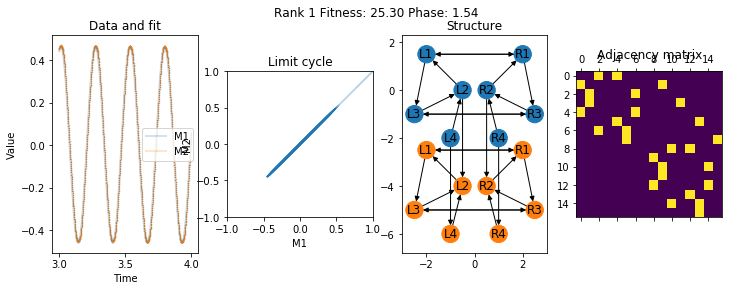

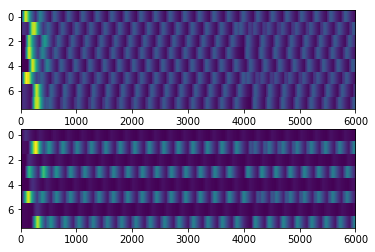

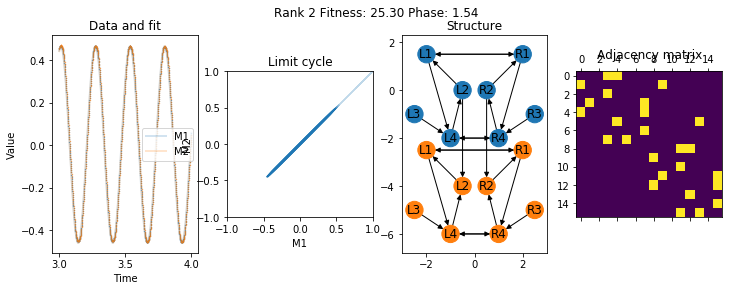

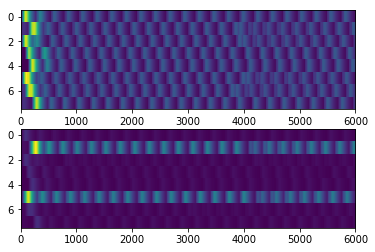

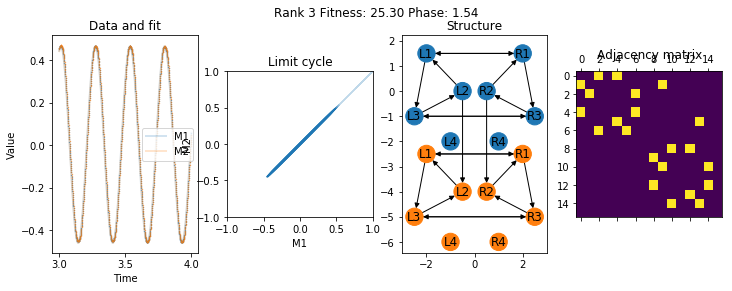

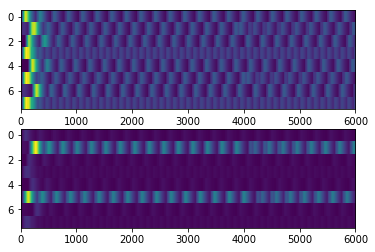

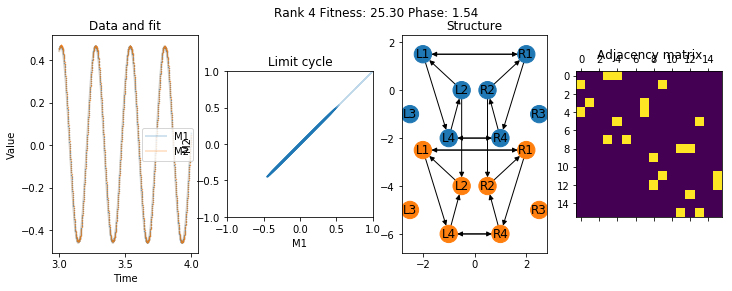

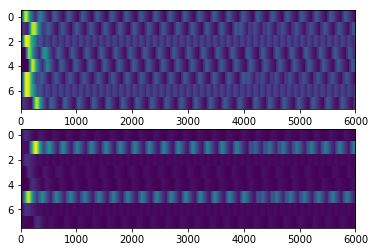

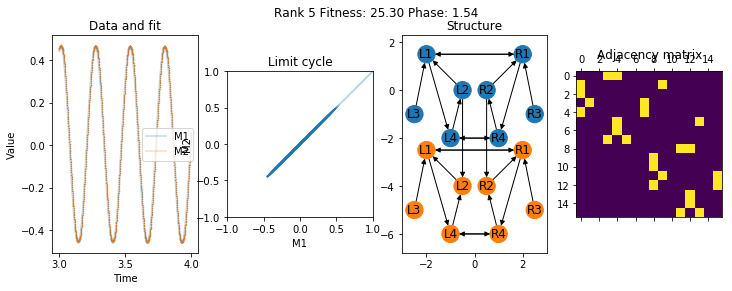

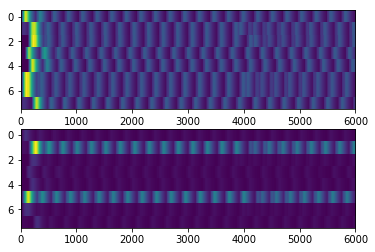

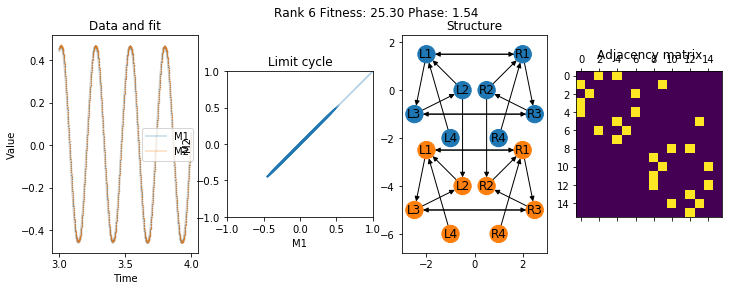

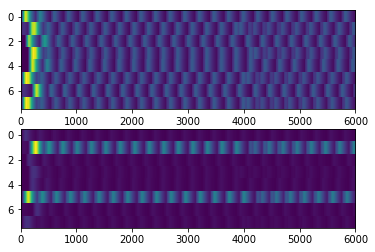

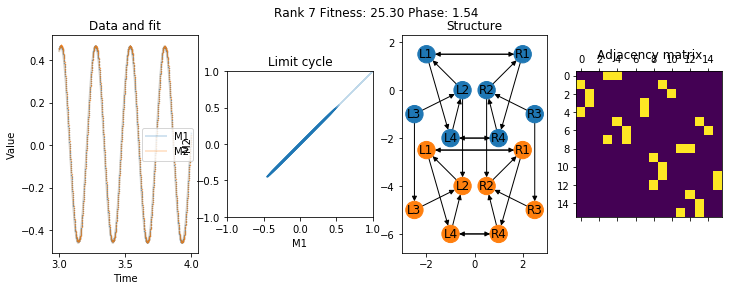

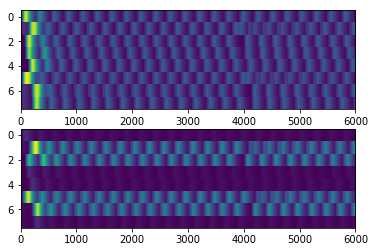

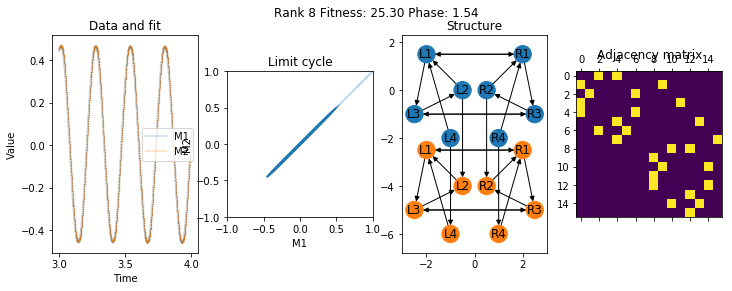

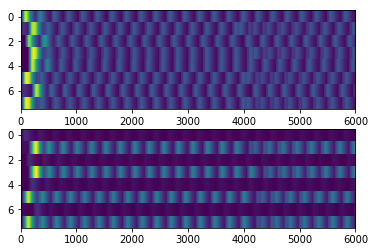

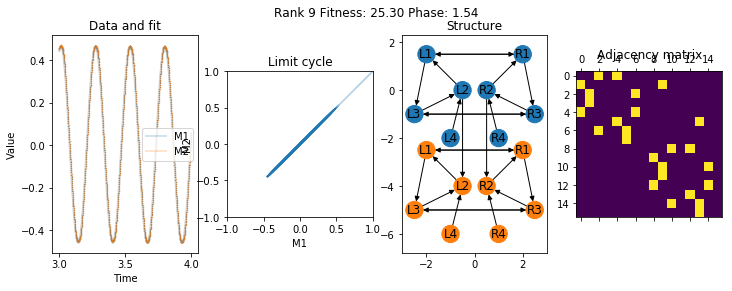

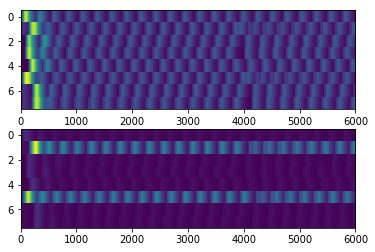

In [228]:
for i,fn in enumerate(top.index):
    process_fn(top,fn, tslc=gtslc)

## Check where fitness starts to increase

ValueError: x and y must be the same size

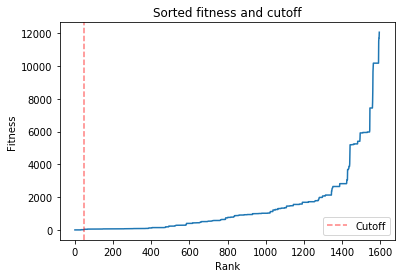

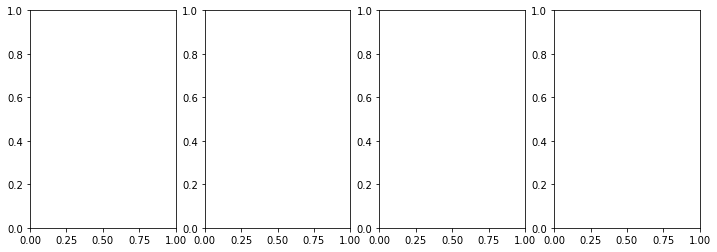

In [196]:
fig, ax = plt.subplots()
ax.plot(fit_sorted['fitness'].to_numpy())
ebreak_idx = 50
l = ax.axvline(ebreak_idx, ls='--', color='r', alpha=0.5)
ax.set_xlabel('Rank')
ax.set_ylabel('Fitness')
ax.legend([l],['Cutoff'])
ax.title.set_text('Sorted fitness and cutoff')
process_fn(fit_sorted,fit_sorted.iloc[ebreak_idx].name)
process_fn(fit_sorted,fit_sorted.iloc[ebreak_idx+100].name)

In [121]:
top_n = 100
top = fit_sorted.head(top_n)
def add_metadata(idx):
    with open(os.path.join(datapath,idx), 'rb') as fp:
        ret = pickle.load(fp)
    return [ret['_metadata']]
top['_metadata'] = top.index.map(add_metadata)

top.to_pickle('top_sin_fit_{}'.format(top_n))

/home/raph/.local/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [122]:
top

,err1,cov1,a1,b1,c1,e1,err2,cov2,a2,b2,c2,e2,fit1,fit2,fitness,phase_diff,_metadata
rZc8fKcZcJclcJcOf7cBc5ckcJf7fAcVc2flczcGcAflcrcZc3cGcycJcQcJcBcLcBf9c4cQcEcqcrc1cDc1cLf9cgc5cKc5.pkl,17.5997,"[[[3.5175875265222195e-08, -5.002779271671162e...",0.462628,24.0129,-3.73498,-0.00615855,14.9327,"[[[2.4611719761293158e-08, 1.3268975327248978e...",0.46322,23.9938,-1.34527,-0.00432253,"[[-0.3339494204163489, -0.32601636632566316, -...","[[0.4587435405736971, 0.45889629208439425, 0.4...",19.636045,3.893479,"[([[0 1 0 0], [0 0 0 1], [0 0 0 0], [1 1 0 0]]..."
qRc8fBcpc0cPcgcYf3cBclcjcEfGfocEc5fpcnckcwfwc7cGcMc9c2cLcXc6cNcOcMf6cocYcWcncVcOcDcNcKcQcncVc6cO.pkl,17.5997,"[[[3.5175875265222195e-08, -5.002779271671162e...",0.462628,24.0129,-3.73498,-0.00615855,14.9327,"[[[2.4611719761293158e-08, 1.3268975327248978e...",0.46322,23.9938,-1.34527,-0.00432253,"[[-0.3339494204163489, -0.32601636632566316, -...","[[0.4587435405736971, 0.45889629208439425, 0.4...",19.636045,3.893479,"[([[0 1 0 0], [0 0 0 1], [0 0 0 0], [1 1 0 0]]..."
qRcPcBcKf7fPcgcwcxfBclcjcJcGfocEc5fpcnckcLcwc7cGcMc9c2cLcXc6cNcgfjc6cocYcWcncVcOcDcNcLfQcncVc6cO.pkl,19.9033,"[[[4.611367466767435e-08, 2.74468351609224e-09...",0.462976,24.0097,-5.991,-0.00748068,17.8913,"[[[3.6304149656035915e-08, 2.1436510552022386e...",0.46311,24.003,-2.71851,0.00625934,"[[-0.04846422679737572, -0.059523626436999655,...","[[0.09799473062114064, 0.10886302147214615, 0....",21.384370,3.010693,"[([[0 0 0 1], [1 0 0 0], [1 0 0 0], [0 1 0 0]]..."
pwcNcRc2fXfQc7crcAc9fAczcrcMf9cncMfvcPcxcEcrczcYc6c5c0cZcXclcNcof7coc7cOcNcJcNc2cOcjc8cQclcXczcj.pkl,19.9033,"[[[4.611367466767435e-08, 2.74468351609224e-09...",0.462976,24.0097,-5.991,-0.00748068,17.8913,"[[[3.6304149656035915e-08, 2.1436510552022386e...",0.46311,24.003,-2.71851,0.00625934,"[[-0.04846422679737572, -0.059523626436999655,...","[[0.09799473062114064, 0.10886302147214615, 0....",21.384370,3.010693,"[([[0 0 0 1], [1 0 0 0], [0 1 0 0], [0 1 0 0]]..."
pwcNcRc2fXfQc7crcAcqcAczcrcMf9cncMfvcPcxcEcrczcYc6c5c0cZcXclcNcof7coc7cOcNcJcNc2cOcjcZfQclcXczcj.pkl,19.9033,"[[[4.611367466767435e-08, 2.74468351609224e-09...",0.462976,24.0097,-5.991,-0.00748068,17.8913,"[[[3.6304149656035915e-08, 2.1436510552022386e...",0.46311,24.003,-2.71851,0.00625934,"[[-0.04846422679737572, -0.059523626436999655,...","[[0.09799473062114064, 0.10886302147214615, 0....",21.384370,3.010693,"[([[0 0 0 1], [1 0 0 0], [0 0 0 0], [0 1 0 0]]..."
pwcnfRcNcRcQc7cnfAcqcAckfjfpc9cncMfvcPcxcEcXfzcYc6c5c0cZcXclcNcxc7coc7cOcNc8fNc2cOcjc8cQclcXczcZ.pkl,19.9033,"[[[4.611367466767435e-08, 2.74468351609224e-09...",0.462976,24.0097,-5.991,-0.00748068,17.8913,"[[[3.6304149656035915e-08, 2.1436510552022386e...",0.46311,24.003,-2.71851,0.00625934,"[[-0.04846422679737572, -0.059523626436999655,...","[[0.09799473062114064, 0.10886302147214615, 0....",21.384370,3.010693,"[([[0 1 0 0], [0 0 0 1], [0 0 0 1], [1 0 0 0]]..."
oRcLc1f8c4cQcWcqcDcOcqcnf7fncQcZcgfLc7cocrcpcVc8cRc1cWfjcQc7c6cEc0cLcocjcwcBcMcXcZcRcNfEc9cGcDcq.pkl,19.9033,"[[[4.611367466767435e-08, 2.74468351609224e-09...",0.462976,24.0097,-5.991,-0.00748068,17.8913,"[[[3.6304149656035915e-08, 2.1436510552022386e...",0.46311,24.003,-2.71851,0.00625934,"[[-0.04846422679737572, -0.059523626436999655,...","[[0.09799473062114064, 0.10886302147214615, 0....",21.384370,3.010693,"[([[0 0 1 0], [0 0 0 0], [0 0 0 1], [1 0 0 0]]..."
qRc8fBcpc0cPc9fwcxfBclcjcEfgcocEc5fpcnckcLcDf7cGcMc9c2cLcXc6cNcOcjc6cocYcWcgfVcOcDcNcKcQcncVc6cO.pkl,19.9033,"[[[4.611367466767435e-08, 2.74468351609224e-09...",0.462976,24.0097,-5.991,-0.00748068,17.8913,"[[[3.6304149656035915e-08, 2.1436510552022386e...",0.46311,24.003,-2.71851,0.00625934,"[[-0.04846422679737572, -0.059523626436999655,...","[[0.09799473062114064, 0.10886302147214615, 0....",21.384370,3.010693,"[([[0 1 0 0], [0 0 1 0], [1 0 0 0], [1 0 0 0]]..."
qRcPcZfpc0cPcgcYf3cBclc8fEfgcocEc5fpcnckcLcwc7cGcMc9cyfLcXc6cNcOcjc6cocYcWcgfVcOcDcNcLfQcncVc6cG.pkl,19.9033,"[[[4.611367466767435e-08, 2.74468351609224e-09...",0.462976,24

In [130]:
with open(time.strftime("top_preformer_%m%d%y_%H%M%S.pkl"),'wb') as fp:
    pickle.dump(top.iloc[0]['_metadata'],fp)